In [1]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
import plotly.express as px
from plotly.offline import init_notebook_mode
init_notebook_mode(connected = True)

In [2]:
data = pd.read_csv('Mall_Customers.csv', index_col='CustomerID')
data.head()

,Gender,Age,Annual Income (k$),Spending Score (1-100)
CustomerID,,,,
1,Male,19,15,39
2,Male,21,15,81
3,Female,20,16,6
4,Female,23,16,77
5,Female,31,17,40


# EDA

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 200 entries, 1 to 200
Data columns (total 4 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   Gender                  200 non-null    object
 1   Age                     200 non-null    int64 
 2   Annual Income (k$)      200 non-null    int64 
 3   Spending Score (1-100)  200 non-null    int64 
dtypes: int64(3), object(1)
memory usage: 7.8+ KB


In [4]:
categorical_cols = ['Gender']
numerical_cols = ['Age', 'Annual Income (k$)', 'Spending Score (1-100)']

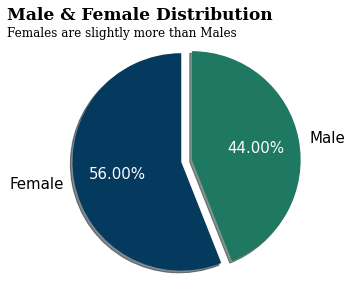

In [5]:
# See the distribution of data wrt the gender predictor

plt.figure(figsize=(5, 5))
patches, texts, autotexts = plt.pie(data['Gender'].value_counts(), autopct='%1.2f%%', 
                                    labels=data.groupby('Gender').count().reset_index()['Gender'],
                                    shadow=True, startangle=90, explode=(0.05, 0.05), colors=['#033a5e', '#1f7862']);
plt.setp(texts, size=15);
plt.setp(autotexts, size=15, color='white');
plt.text(-1.65, 1.3, 'Male & Female Distribution', fontfamily='serif', fontsize=17, fontweight='bold');
plt.text(-1.65, 1.15, 'Females are slightly more than Males', fontfamily='serif', fontsize=12);
plt.show()

Text(1, 22, 'Spending Score (1-100) Distribution')

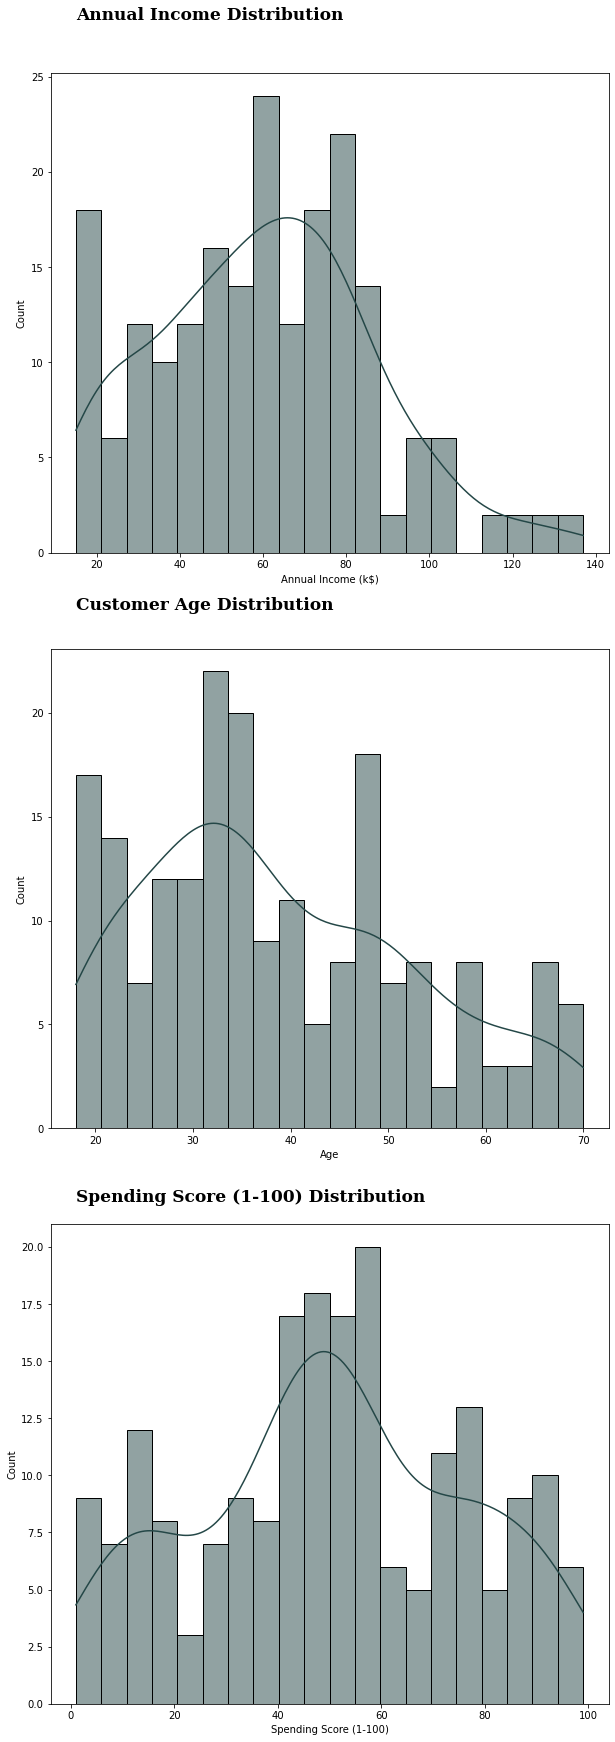

In [6]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(10, 30))
sns.histplot(x="Annual Income (k$)", data=data, kde=True, bins=20, color='#244747', ax=ax1)
ax1.text(15, 28, 'Annual Income Distribution', fontfamily='serif', fontsize=17, fontweight='bold')
sns.histplot(x="Age", data=data, kde=True, bins=20, color='#244747', ax=ax2)
ax2.text(18, 25, 'Customer Age Distribution', fontfamily='serif', fontsize=17, fontweight='bold')
sns.histplot(x="Spending Score (1-100)", data=data, kde=True, bins=20, color='#244747', ax=ax3)
ax3.text(1, 22, 'Spending Score (1-100) Distribution', fontfamily='serif', fontsize=17, fontweight='bold')

In [7]:
# Label encode the categorical data
from sklearn.preprocessing import LabelEncoder

df = data.copy()

for predictor in categorical_cols:
    le = LabelEncoder()
    df[predictor] = le.fit_transform(df[predictor])

## Correlations

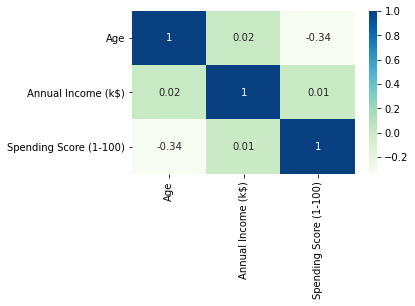

In [8]:
# Deafult methos is Pearson which assumes the data is normally distributed Spearman doesn't have any assumptions
plt.figure(figsize=(5, 3))
sns.heatmap(round(data[numerical_cols].corr(method='spearman'), 2), 
            annot=True, mask=None, cmap='GnBu')
plt.show()

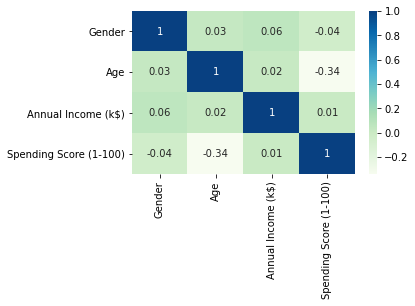

In [9]:
plt.figure(figsize=(5, 3))
sns.heatmap(round(df.corr(method='spearman'), 2), 
            annot=True, mask=None, cmap='GnBu')
plt.show()

## Analyse the effect of outliers

In [10]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

vif = pd.DataFrame()
temp = df.dropna()
vif["variables"] = [feature for feature in df.columns]
vif["VIF"] = [variance_inflation_factor(temp[vif['variables']].values, i) for i in range(len(vif["variables"]))]
print(vif)

                variables       VIF
0                  Gender  1.763377
1                     Age  4.462126
2      Annual Income (k$)  4.975172
3  Spending Score (1-100)  3.298030


__No influence of outliers and implies that all predictors can be used__

In [11]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, rand_score
from sklearn.mixture import GaussianMixture
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import AgglomerativeClustering

# K-Means

## Model excluding Gender & Age features

In [12]:
feature_cols = [feature for feature in df.columns if feature not in(['Gender', 'Age'])]
train_data = df.copy()[feature_cols]
print('features used- ', feature_cols)

features used-  ['Annual Income (k$)', 'Spending Score (1-100)']


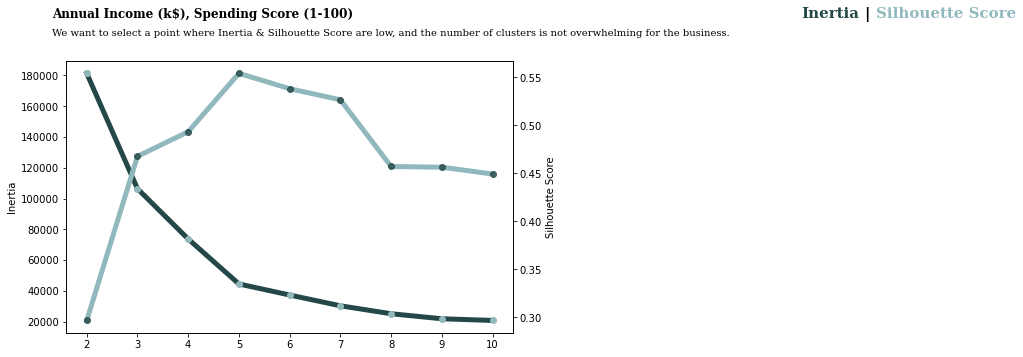

In [13]:
# Using ELBOW Method to figure out number of clusters
inertia=[]
silhouetteScore = []
for i in range(2,11):
    kmeans = KMeans(n_clusters= i, init='k-means++', random_state=0)
    kmeans.fit(train_data)
    inertia.append(kmeans.inertia_)
    silhouetteScore.append(silhouette_score(train_data, kmeans.predict(train_data)))

fig, ax1 = plt.subplots(figsize=(8, 5))
fig.text(0.1, 1, ', '.join(feature_cols), fontfamily='serif', fontsize=12, fontweight='bold')
fig.text(0.1, 0.95, 'We want to select a point where Inertia & Silhouette Score are low, and the number of clusters is not overwhelming for the business.',
         fontfamily='serif',fontsize=10)
fig.text(1.4, 1, 'Inertia', fontweight="bold", fontfamily='serif', fontsize=15, color='#244747')
fig.text(1.51, 1, "|", fontweight="bold", fontfamily='serif', fontsize=15, color='black')
fig.text(1.53, 1, 'Silhouette Score', fontweight="bold", fontfamily='serif', fontsize=15, color='#91b8bd')

ax1.plot(range(2,11), inertia, '-', color='#244747', linewidth=5)
ax1.plot(range(2,11), inertia, 'o', color='#91b8bd')
ax1.set_ylabel('Inertia')

ax2 = ax1.twinx()
ax2.plot(range(2,11), silhouetteScore, '-', color='#91b8bd', linewidth=5)
ax2.plot(range(2,11), silhouetteScore, 'o', color='#244747', alpha=0.8)
ax2.set_ylabel('Silhouette Score')

plt.xlabel('Number of clusters')
plt.show()

In [14]:
model = KMeans(n_clusters=5, init='k-means++', random_state=111, algorithm='elkan')
y = model.fit_predict(train_data[feature_cols])

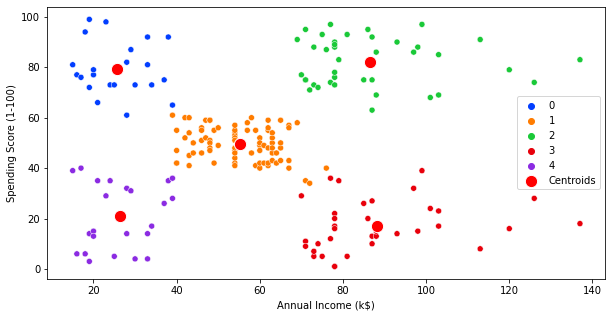

In [15]:
plt.figure(figsize=(10, 5))
sns.scatterplot(x=feature_cols[0], y=feature_cols[1],
                data=train_data, hue=y,
                palette=sns.color_palette('bright', model.n_clusters))
sns.scatterplot(x=model.cluster_centers_[:, 0], y=model.cluster_centers_[:, 1],
                label='Centroids', s=150, color='Red')
plt.show()

*Cluster intution*

* Cluster-0 : People with Low income and high Spending habit (not much revenue possible)
* Cluster-1 : People with moderate income and spending habit
* Cluster-2 : People with high income and spending habit (high revenue already achieved)
* Cluster-3 : People with high income and low spending habit (can advertise)
* Cluster-4 : People with low income and low spending habit

## Model excluding Gender feature

In [16]:
feature_cols = [feature for feature in df.columns if feature not in(['Gender'])]
train_data = df.copy()[feature_cols]
print('features used- ', feature_cols)

features used-  ['Age', 'Annual Income (k$)', 'Spending Score (1-100)']


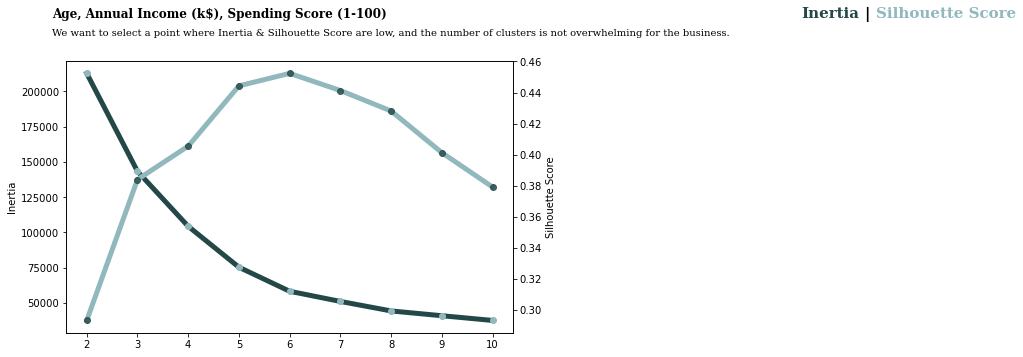

In [17]:
# Using ELBOW Method to figure out number of clusters
inertia=[]
silhouetteScore = []
for i in range(2,11):
    kmeans = KMeans(n_clusters= i, init='k-means++', random_state=0)
    kmeans.fit(train_data)
    inertia.append(kmeans.inertia_)
    silhouetteScore.append(silhouette_score(train_data, kmeans.predict(train_data)))

fig, ax1 = plt.subplots(figsize=(8, 5))
fig.text(0.1, 1, ', '.join(feature_cols), fontfamily='serif', fontsize=12, fontweight='bold')
fig.text(0.1, 0.95, 'We want to select a point where Inertia & Silhouette Score are low, and the number of clusters is not overwhelming for the business.',
         fontfamily='serif',fontsize=10)
fig.text(1.4, 1, 'Inertia', fontweight="bold", fontfamily='serif', fontsize=15, color='#244747')
fig.text(1.51, 1, "|", fontweight="bold", fontfamily='serif', fontsize=15, color='black')
fig.text(1.53, 1, 'Silhouette Score', fontweight="bold", fontfamily='serif', fontsize=15, color='#91b8bd')

ax1.plot(range(2,11), inertia, '-', color='#244747', linewidth=5)
ax1.plot(range(2,11), inertia, 'o', color='#91b8bd')
ax1.set_ylabel('Inertia')

ax2 = ax1.twinx()
ax2.plot(range(2,11), silhouetteScore, '-', color='#91b8bd', linewidth=5)
ax2.plot(range(2,11), silhouetteScore, 'o', color='#244747', alpha=0.8)
ax2.set_ylabel('Silhouette Score')

plt.xlabel('Number of clusters')
plt.show()

In [18]:
model = KMeans(n_clusters=6, init='k-means++', random_state=111, algorithm='elkan')
y = model.fit_predict(train_data[feature_cols])

In [19]:
fig = px.scatter_3d(train_data, x="Annual Income (k$)", y="Spending Score (1-100)", z="Age",
                    color=y, opacity=0.8, size=y+1)
fig.show()

In [20]:
# Interpreting the clusters
train_data['cluster'] = y
train_data.groupby(['cluster']).agg(['mean', 'median']).reset_index()

cluster        Age        Annual Income (k$)        Spending Score (1-100)  \
                mean median               mean median                   mean   
0       0  27.000000   26.5          56.657895   59.5              49.131579   
1       1  41.685714   43.0          88.228571   85.0              17.285714   
2       2  56.155556   54.0          53.377778   54.0              49.088889   
3       3  32.692308   32.0          86.538462   79.0              82.128205   
4       4  44.142857   45.0          25.142857   24.0              19.523810   
5       5  25.272727   23.5          25.727273   24.5              79.363636   

          
  median  
0     50  
1     16  
2     49  
3     83  
4     15  
5     77

* Cluster 0 - Moderate spending score, Moderate income, young age - Valuable
* Cluster 1 - Low spending score, High income, moderate age - Targets
* Cluster 2 - High spending score, High income, young age - Most Valuable
* Cluster 3 - Moderate spending score, Moderate income, old age - Less Valuable
* Cluster 4 - High spending score, low income, young age - More Valuable
* Cluster 5 - Low spending score, low income, moderate age - Least Valuable

In [21]:
data['cluster'] = train_data['cluster']

plot_data = data.groupby(['cluster', 'Gender'])['cluster'].agg({'count'}).reset_index()

fig = px.sunburst(plot_data, path=['cluster', 'Gender'], values='count',
                  title='Affect of cluster on Customer Gender',
                  width = 600, height = 600)

fig.update_layout(plot_bgcolor='white', title_font_family='Calibri Black', title_font_color='#221f1f', 
                  title_font_size=22, title_x=0.5)
fig.update_traces(textinfo = 'label + percent root')
fig.show()

# Hierarchical clustering

In [22]:
feature_cols = [feature for feature in df.columns if feature not in(['Gender', 'Age'])]
train_data = df.copy()[feature_cols]
print('features used- ', feature_cols)

features used-  ['Annual Income (k$)', 'Spending Score (1-100)']


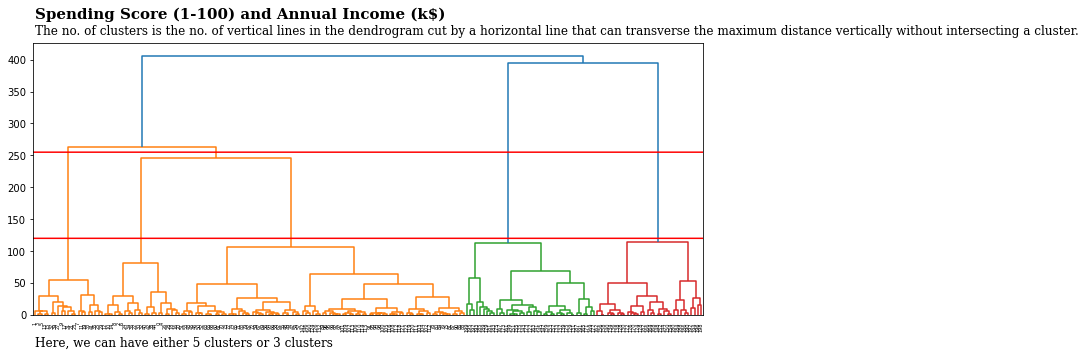

In [23]:
plt.figure(figsize = (12, 5))
plt.text(5, 465, 'Spending Score (1-100) and Annual Income (k$)', fontfamily='serif', fontsize=15, fontweight='bold')
plt.text(5, 440, 'The no. of clusters is the no. of vertical lines in the dendrogram cut by a horizontal line that can transverse the maximum distance vertically without intersecting a cluster.',
         fontfamily='serif',fontsize=12)
dendo = dendrogram(linkage(train_data[feature_cols], method = 'ward'))
plt.plot([120]*2000, color='r')
plt.plot([255]*2000, color='r')
plt.text(5, -50, 'Here, we can have either 5 clusters or 3 clusters',
         fontfamily='serif',fontsize=12)
plt.show()

In [24]:
model = AgglomerativeClustering(n_clusters = 5, affinity='euclidean', linkage='ward')
y = model.fit_predict(train_data[feature_cols])

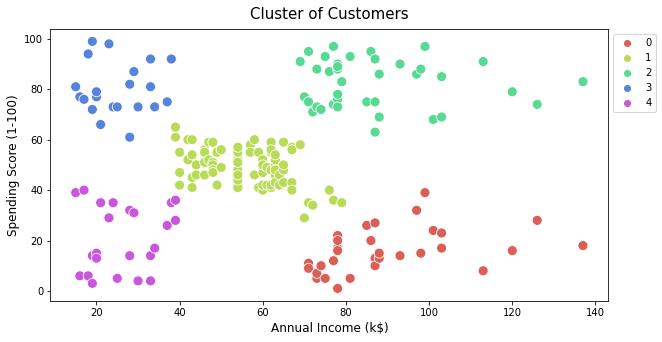

In [25]:
# Visualizing all the clusters 
plt.figure(figsize=(10,5))
sns.scatterplot(x=train_data[feature_cols[0]], y=train_data[feature_cols[1]], 
                hue=y, palette=sns.color_palette('hls', 5), s=100)
plt.title('Cluster of Customers'.format(feature_cols[0], feature_cols[1]), size=15, pad=10)
plt.xlabel(feature_cols[0], size=12)
plt.ylabel(feature_cols[1], size=12)
plt.legend(loc=0, bbox_to_anchor=[1,1])
plt.show()